In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'ai-indian-license-plate-recognition-data:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F827967%2F1414839%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240520%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240520T153548Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D42b4ba89aa2eea5a7726e7de61f2193076959dffaf84ce552174d86de23bc97465a3808be31017ae4515a1405ef5beb026d0fc75c5ee2e937c318c96787a9bee3b05cbaae1ac6372e5116783f0492da63193523cee64bf87fcc6d193cffad918e8555b03389d4c8f08f1be457f5b8f4b03eb21f469b3c5f092f9d7d4d7c9697211863f1fda82fce312882ca13c267f31837b573d681bd7beb37230f20d0e6f1b63f15f35ccc065984366a990ffd97241d9c84879261e26f24189beebefaf5a8d19d06da3644d716da49b8e09f260de5a3fe2a09d53626b72cdcf75e574c935456011b795dbd28a402c9710527da46eba9624c71977a34456387a4ff62be1d049'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 1573971 bytes downloaded
Downloaded and uncompressed: ai-indian-license-plate-recognition-data
Data source import complete.


In [68]:
from warnings import filterwarnings
filterwarnings(action="ignore")

import cv2
import copy
from PIL import Image
from tqdm.auto import tqdm
from glob import glob as glb

import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder

import albumentations as A

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

from torchvision import transforms as T


from tensorflow.keras.preprocessing.image import ImageDataGenerator

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

print("Libraries Loaded")

Libraries Loaded


In [3]:
torch.__version__

'2.2.1+cu121'

In [4]:
torch.manual_seed(999)

np.random.seed(999)

In [5]:
def GetImgAsDf(split_type:str):
    image_path = glb(f"/kaggle/input/ai-indian-license-plate-recognition-data/data/data/{split_type}/*/*.jpg")
    image_label = [i.split("/")[-2][-1] for i in image_path]
    return pd.DataFrame({
        "img_pth":image_path,
        "img_lbl":image_label
    })

In [6]:
train_df = GetImgAsDf("train")
val_df = GetImgAsDf("val")

train_df.shape, val_df.shape

((864, 2), (216, 2))

In [7]:
train_df.head()

,img_pth,img_lbl
0,/kaggle/input/ai-indian-license-plate-recognit...,E
1,/kaggle/input/ai-indian-license-plate-recognit...,E
2,/kaggle/input/ai-indian-license-plate-recognit...,E
3,/kaggle/input/ai-indian-license-plate-recognit...,E
4,/kaggle/input/ai-indian-license-plate-recognit...,E


In [8]:
val_df.head()

,img_pth,img_lbl
0,/kaggle/input/ai-indian-license-plate-recognit...,E
1,/kaggle/input/ai-indian-license-plate-recognit...,E
2,/kaggle/input/ai-indian-license-plate-recognit...,E
3,/kaggle/input/ai-indian-license-plate-recognit...,E
4,/kaggle/input/ai-indian-license-plate-recognit...,E


In [9]:
def PlotTargetDist(df, split_type:str):
    val_count = df["img_lbl"].value_counts().plot(kind="bar",
                                                  color="k",
                                                  title=f"Target Distribution for {split_type} dataset",
                                                  figsize=(18, 6),
                                                  xlabel="Label",
                                                  ylabel="Counts")

    val_count.set_xticklabels(labels=val_count.get_xticklabels(), rotation=0)

    for p in val_count.patches:
        h = p.get_height()
        val_count.text(p.get_x()+(p.get_width()/2), h, h, va="bottom", ha="center")

    return val_count

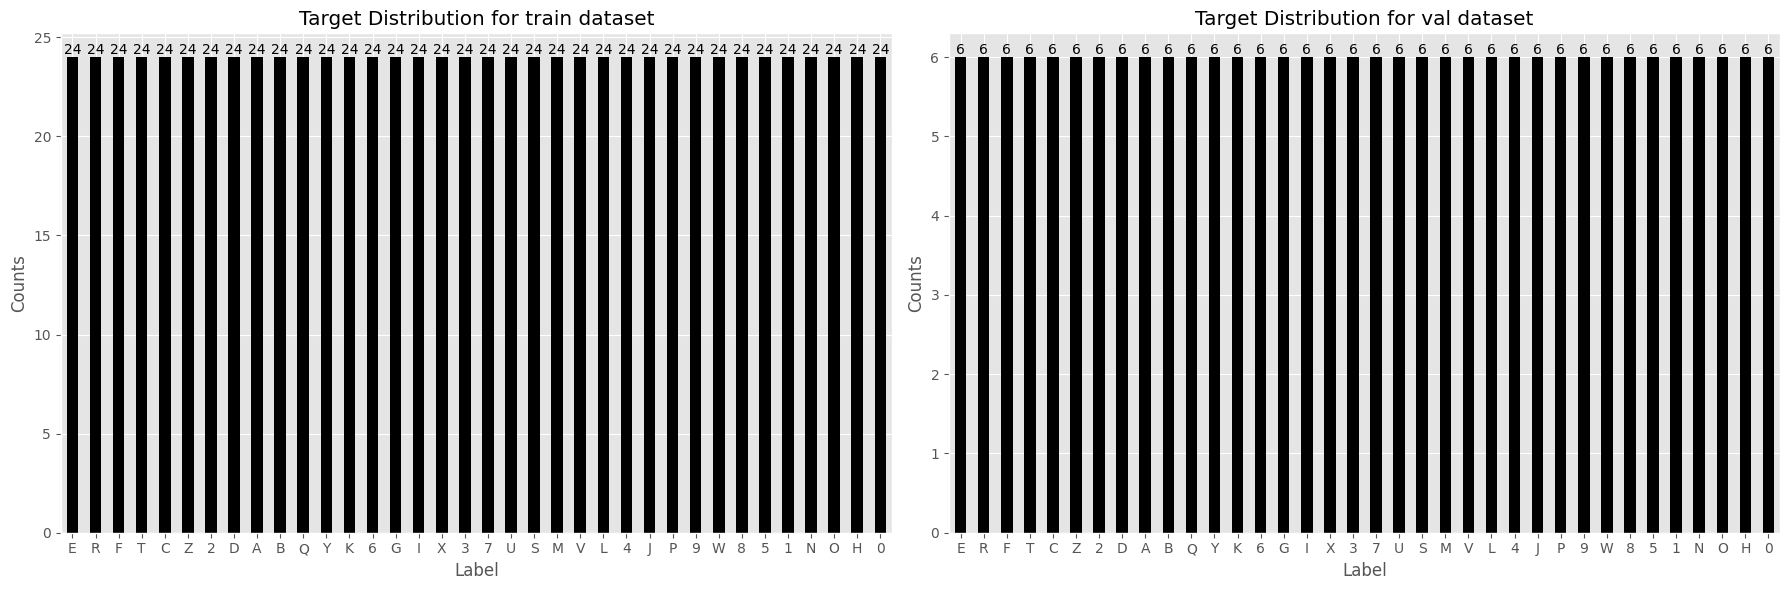

In [10]:
for idx, (df, st) in enumerate(zip([train_df, val_df], ["train", "val"]), start=1):
    plt.subplot(1, 2, idx)
    PlotTargetDist(df, st)

plt.tight_layout()
plt.show()

In [11]:
combine_df = pd.concat([train_df, val_df])

print(combine_df.shape)

combine_df.head()

(1080, 2)


,img_pth,img_lbl
0,/kaggle/input/ai-indian-license-plate-recognit...,E
1,/kaggle/input/ai-indian-license-plate-recognit...,E
2,/kaggle/input/ai-indian-license-plate-recognit...,E
3,/kaggle/input/ai-indian-license-plate-recognit...,E
4,/kaggle/input/ai-indian-license-plate-recognit...,E


In [12]:
encoder = LabelEncoder()

combine_df["enc_lbl"] = encoder.fit_transform(combine_df["img_lbl"])

In [13]:
lbl_classes = {j:i for i, j in zip(encoder.classes_, range(len(encoder.classes_)))}

print(len(lbl_classes))
print(lbl_classes)

36
{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 17: 'H', 18: 'I', 19: 'J', 20: 'K', 21: 'L', 22: 'M', 23: 'N', 24: 'O', 25: 'P', 26: 'Q', 27: 'R', 28: 'S', 29: 'T', 30: 'U', 31: 'V', 32: 'W', 33: 'X', 34: 'Y', 35: 'Z'}


In [14]:
train_df_ = combine_df[:train_df.shape[0]]
val_df_ = combine_df[train_df.shape[0]:]

print(train_df_.shape, val_df_.shape)

(864, 3) (216, 3)


In [15]:
class ImageLoaderCls(Dataset):
    def __init__(self, df, aug=None):
        self.X = df["img_pth"]
        self.y = df["enc_lbl"]

        if not aug:
            self.aug = A.Compose([
                A.Resize(height=64, width=64, always_apply=True),
                A.Normalize(always_apply=True)
            ])
        else:
            self.aug = aug

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        try:
            open_img = Image.open(self.X[index])
            conv_img_to_rgb = open_img.convert("RGB")
            augment_img = self.aug(image=np.array(conv_img_to_rgb))["image"]
            augment_img_lbl = self.y[index]
        except:
            raise RuntimeError(f"Error loading image at index {index}")

        return torch.permute(torch.tensor(augment_img, dtype=torch.float32), (2, 0, 1)), torch.tensor(augment_img_lbl, dtype=torch.long)

def Dataloader(train, val, batch_size:int): return DataLoader(train, batch_size=batch_size, shuffle=True), DataLoader(val, batch_size=batch_size, shuffle=True)

In [16]:
load_train_images = ImageLoaderCls(train_df_)
load_val_images = ImageLoaderCls(val_df_)

train_dataloader, val_dataloader = Dataloader(load_train_images, load_val_images, batch_size=5)

print("Sucessfully Loaded Data")

Sucessfully Loaded Data


In [17]:
train_batch_x, train_batch_y = next(iter(train_dataloader))

print(train_batch_x.shape, train_batch_y.shape)

torch.Size([5, 3, 64, 64]) torch.Size([5])


In [18]:
val_batch_x, val_batch_y = next(iter(val_dataloader))

print(val_batch_x.shape, val_batch_y.shape)

torch.Size([5, 3, 64, 64]) torch.Size([5])


In [19]:
def PlotBatch(nrow, ncol, batch_x, batch_y, suptitle):
    plt.figure(figsize=(5, 5))
    for i in range(1, nrow+ncol+1):
        plt.subplot(nrow, ncol, i)
        plt.imshow(torch.permute(batch_x[i-1], dims=(1, 2, 0)))
        plt.title(f"Label -> {lbl_classes[batch_y[i-1].item()]}")
        plt.axis("off")

    plt.suptitle(suptitle, x=0.1, y=1)
    plt.tight_layout()
    plt.show()

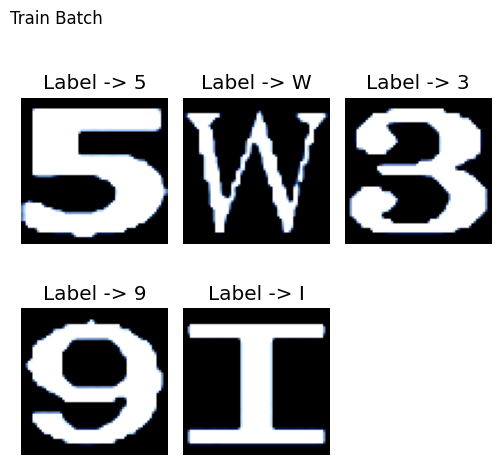

In [20]:
PlotBatch(nrow=2, ncol=3, batch_x=train_batch_x, batch_y=train_batch_y, suptitle="Train Batch")

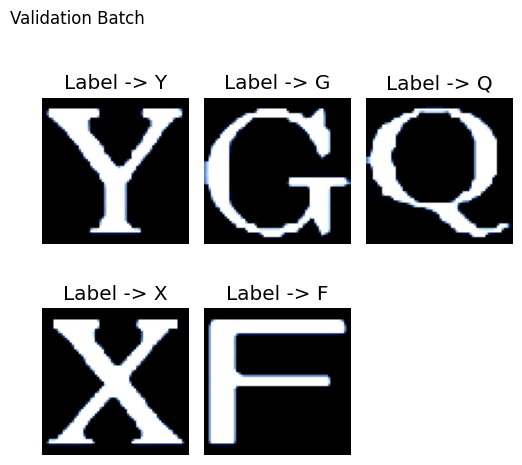

In [21]:
PlotBatch(nrow=2, ncol=3, batch_x=val_batch_x, batch_y=val_batch_y,suptitle="Validation Batch")

In [22]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_model_wts = None
        self.best_loss = float('inf')
        self.counter = 0
        self.status = ""

    def __call__(self, model, val_loss):
        if self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model_wts = copy.deepcopy(model.state_dict())
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.status = f"Stopped on {self.counter}"
                if self.restore_best_weights and self.best_model_wts is not None:
                    model.load_state_dict(self.best_model_wts)
                return True
        self.status = f"{self.counter}/{self.patience}"
        return False

In [23]:
class DataTrainer():
    def __init__(self, model, dataloader: list, optimizer, loss_function, lr_scheduler=None, early_stopping=None):
        self.optim = optimizer
        self.dataloader = dataloader
        self.loss_func = loss_function
        self.device = "cuda:0" if torch.cuda.is_available() else "cpu"
        self.model = model.to(self.device)
        self.lr_scheduler = lr_scheduler
        self.early_stopping = early_stopping
        self.best_model_wts = copy.deepcopy(self.model.state_dict())
        self.best_val_acc = 0.0

    def train_model(self):
        training_loss = 0
        total_correct = 0

        self.model.train()

        for data in tqdm(self.dataloader[0], total=len(self.dataloader[0])):
            X, y = data[0].to(self.device), data[1].to(self.device)

            self.optim.zero_grad()

            model_output = self.model(X)

            model_loss = self.loss_func(model_output, y)

            training_loss += model_loss.item()

            model_prediction = torch.argmax(model_output, dim=1)

            total_correct += (model_prediction == y).sum().item()

            model_loss.backward()

            self.optim.step()

        final_train_loss = training_loss / len(self.dataloader[0])
        final_train_accuracy = total_correct / len(self.dataloader[0].dataset)

        return final_train_accuracy, final_train_loss

    def validate_model(self):
        val_loss = 0
        total_correct = 0

        self.model.eval()

        with torch.no_grad():
            for data in tqdm(self.dataloader[1], total=len(self.dataloader[1])):
                X, y = data[0].to(self.device), data[1].to(self.device)

                output = self.model(X)

                model_loss = self.loss_func(output, y)

                val_loss += model_loss.item()

                model_prediction = torch.argmax(output, dim=1)

                total_correct += (model_prediction == y).sum().item()

        final_val_loss = val_loss / len(self.dataloader[1])
        final_val_accuracy = total_correct / len(self.dataloader[1].dataset)

        return final_val_accuracy, final_val_loss

    def fit(self, epoch: int):
        train_acc_per_epoch = []
        train_loss_per_epoch = []
        val_acc_per_epoch = []
        val_loss_per_epoch = []

        for i in range(epoch):
            print(f"Epoch: {i + 1}/{epoch}")

            train_acc, train_loss = self.train_model()
            val_acc, val_loss = self.validate_model()

            print(f"Training Accuracy --> {train_acc:.4f} Training Loss --> {train_loss:.4f} Val Accuracy --> {val_acc:.4f} Val Loss --> {val_loss:.4f}")

            train_acc_per_epoch.append(train_acc)
            train_loss_per_epoch.append(train_loss)
            val_acc_per_epoch.append(val_acc)
            val_loss_per_epoch.append(val_loss)

            # Step the scheduler if provided
            if self.lr_scheduler:
                self.lr_scheduler.step(val_loss)

            # Check for early stopping
            if self.early_stopping and self.early_stopping(self.model, val_loss):
                print(f"Early stopping at epoch {i + 1}")
                break

        # Load the best model weights if early stopping is used
        if self.early_stopping and self.early_stopping.best_model_wts is not None:
            print("Returning Best Model Weights")
            self.model.load_state_dict(self.early_stopping.best_model_wts)
        else:
            self.model.load_state_dict(self.best_model_wts)

        history = pd.DataFrame({
            "train_loss": train_loss_per_epoch,
            "train_accuracy": train_acc_per_epoch,
            "val_loss": val_loss_per_epoch,
            "val_accuracy": val_acc_per_epoch
        })

        return {"model": self.model, "history": history}

In [24]:
class DigitClassifier(nn.Module):
    def __init__(self):
        super(DigitClassifier, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Defining a 2D convolution layer
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            # Putting a 2D Batchnorm after CNN layer
            nn.BatchNorm2d(32),
            # Adding Relu Activation
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_layers = nn.Sequential(
            # Adding Dropout
            nn.Dropout(p = 0.5),
            nn.Linear(32 * 32 * 32, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p = 0.5),
            nn.Linear(512, 36),
        )

    # Defining the forward pass
    def forward(self, x):

        # Forward Pass through the CNN Layers
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        # Forwrd pass through Fully Connected Layers
        x = self.linear_layers(x)
        return F.log_softmax(x)

digit_classifier = DigitClassifier()

print(digit_classifier)

DigitClassifier(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=32768, out_features=512, bias=True)
    (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): Dropout(p=0.5, inplace=False)
    (5): Linear(in_features=512, out_features=36, bias=True)
  )
)


In [25]:
loss_func = nn.CrossEntropyLoss()
optimizers = torch.optim.Adam(params=digit_classifier.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizers, mode='min', factor=0.1, patience=3, verbose=True)
early_stopping = EarlyStopping(patience=20, min_delta=0.01, restore_best_weights=True)

train_dataloader_, val_dataloader_ = Dataloader(load_train_images, load_val_images, batch_size=32)

trainer = DataTrainer(digit_classifier,
                      dataloader=[train_dataloader_, val_dataloader_],
                      optimizer=optimizers,
                      loss_function=loss_func,
                      lr_scheduler=scheduler,
                      early_stopping=early_stopping)

In [26]:
# Fit the model
model_result = trainer.fit(epoch=50)

Epoch: 1/50


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Training Accuracy --> 0.7280 Training Loss --> 1.3448 Val Accuracy --> 0.9815 Val Loss --> 0.2915
Epoch: 2/50


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Training Accuracy --> 0.9803 Training Loss --> 0.2487 Val Accuracy --> 0.9769 Val Loss --> 0.1402
Epoch: 3/50


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Training Accuracy --> 0.9896 Training Loss --> 0.1090 Val Accuracy --> 0.9815 Val Loss --> 0.0915
Epoch: 4/50


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Training Accuracy --> 0.9884 Training Loss --> 0.0745 Val Accuracy --> 0.9907 Val Loss --> 0.0606
Epoch: 5/50


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Training Accuracy --> 0.9896 Training Loss --> 0.0584 Val Accuracy --> 0.9907 Val Loss --> 0.0420
Epoch: 6/50


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Training Accuracy --> 0.9884 Training Loss --> 0.0427 Val Accuracy --> 0.9954 Val Loss --> 0.0362
Epoch: 7/50


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Training Accuracy --> 0.9942 Training Loss --> 0.0415 Val Accuracy --> 0.9954 Val Loss --> 0.0227
Epoch: 8/50


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Training Accuracy --> 0.9861 Training Loss --> 0.0421 Val Accuracy --> 0.9954 Val Loss --> 0.0361
Epoch: 9/50


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Training Accuracy --> 0.9977 Training Loss --> 0.0274 Val Accuracy --> 0.9954 Val Loss --> 0.0268
Epoch: 10/50


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Training Accuracy --> 0.9942 Training Loss --> 0.0257 Val Accuracy --> 0.9954 Val Loss --> 0.0230
Epoch: 11/50


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Training Accuracy --> 0.9965 Training Loss --> 0.0195 Val Accuracy --> 0.9954 Val Loss --> 0.0206
Epoch: 12/50


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Training Accuracy --> 0.9988 Training Loss --> 0.0152 Val Accuracy --> 0.9954 Val Loss --> 0.0225
Epoch: 13/50


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Training Accuracy --> 0.9954 Training Loss --> 0.0206 Val Accuracy --> 0.9954 Val Loss --> 0.0244
Epoch: 14/50


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Training Accuracy --> 0.9965 Training Loss --> 0.0181 Val Accuracy --> 1.0000 Val Loss --> 0.0121
Epoch: 15/50


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Training Accuracy --> 0.9965 Training Loss --> 0.0191 Val Accuracy --> 0.9954 Val Loss --> 0.0153
Epoch: 16/50


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Training Accuracy --> 0.9965 Training Loss --> 0.0127 Val Accuracy --> 0.9954 Val Loss --> 0.0174
Epoch: 17/50


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Training Accuracy --> 0.9988 Training Loss --> 0.0097 Val Accuracy --> 1.0000 Val Loss --> 0.0093
Epoch: 18/50


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Training Accuracy --> 0.9977 Training Loss --> 0.0110 Val Accuracy --> 0.9954 Val Loss --> 0.0166
Epoch: 19/50


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Training Accuracy --> 0.9965 Training Loss --> 0.0136 Val Accuracy --> 1.0000 Val Loss --> 0.0175
Epoch: 20/50


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Training Accuracy --> 0.9965 Training Loss --> 0.0168 Val Accuracy --> 0.9954 Val Loss --> 0.0222
Epoch: 21/50


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Training Accuracy --> 0.9965 Training Loss --> 0.0119 Val Accuracy --> 0.9954 Val Loss --> 0.0164
Epoch: 22/50


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Training Accuracy --> 0.9988 Training Loss --> 0.0078 Val Accuracy --> 0.9954 Val Loss --> 0.0178
Epoch: 23/50


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Training Accuracy --> 0.9988 Training Loss --> 0.0082 Val Accuracy --> 0.9954 Val Loss --> 0.0150
Epoch: 24/50


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Training Accuracy --> 1.0000 Training Loss --> 0.0067 Val Accuracy --> 0.9954 Val Loss --> 0.0139
Epoch: 25/50


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Training Accuracy --> 1.0000 Training Loss --> 0.0062 Val Accuracy --> 0.9954 Val Loss --> 0.0137
Epoch: 26/50


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Training Accuracy --> 1.0000 Training Loss --> 0.0046 Val Accuracy --> 0.9954 Val Loss --> 0.0129
Epoch: 27/50


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Training Accuracy --> 1.0000 Training Loss --> 0.0060 Val Accuracy --> 0.9954 Val Loss --> 0.0133
Epoch: 28/50


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Training Accuracy --> 1.0000 Training Loss --> 0.0050 Val Accuracy --> 0.9954 Val Loss --> 0.0140
Epoch: 29/50


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Training Accuracy --> 0.9988 Training Loss --> 0.0062 Val Accuracy --> 0.9954 Val Loss --> 0.0134
Epoch: 30/50


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Training Accuracy --> 1.0000 Training Loss --> 0.0050 Val Accuracy --> 0.9954 Val Loss --> 0.0124
Epoch: 31/50


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Training Accuracy --> 0.9954 Training Loss --> 0.0134 Val Accuracy --> 0.9954 Val Loss --> 0.0124
Epoch: 32/50


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Training Accuracy --> 1.0000 Training Loss --> 0.0054 Val Accuracy --> 0.9907 Val Loss --> 0.0147
Epoch: 33/50


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Training Accuracy --> 0.9988 Training Loss --> 0.0070 Val Accuracy --> 0.9954 Val Loss --> 0.0155
Epoch: 34/50


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Training Accuracy --> 0.9988 Training Loss --> 0.0065 Val Accuracy --> 0.9954 Val Loss --> 0.0124
Early stopping at epoch 34


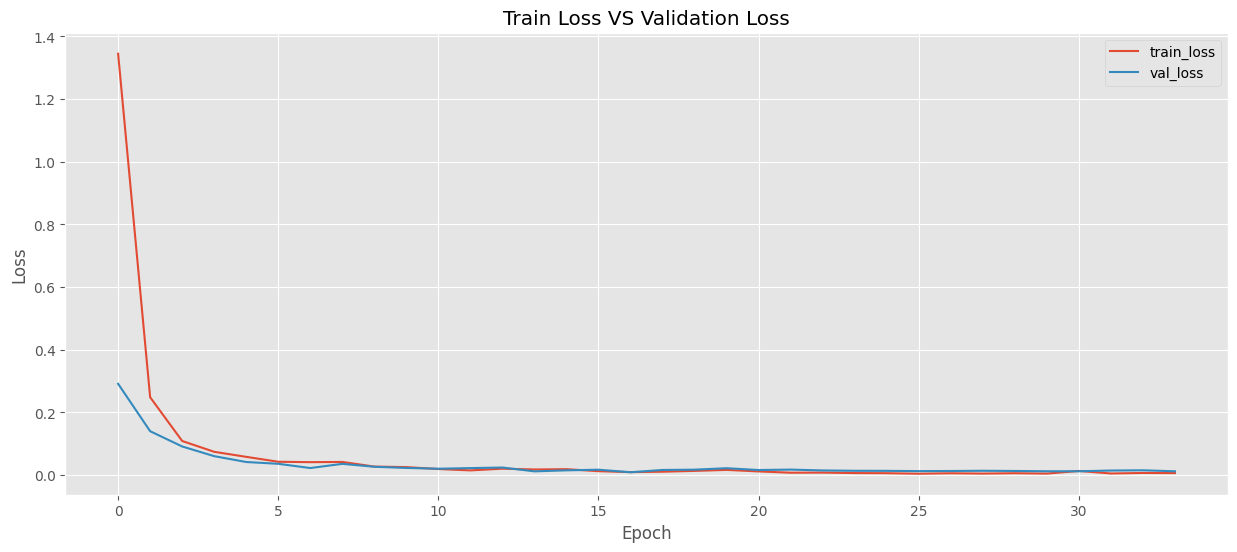

In [27]:
model_result["history"][["train_loss", "val_loss"]].plot(figsize=(15, 6),
                                                         title="Train Loss VS Validation Loss",
                                                         xlabel="Epoch",
                                                         ylabel="Loss")
plt.show()

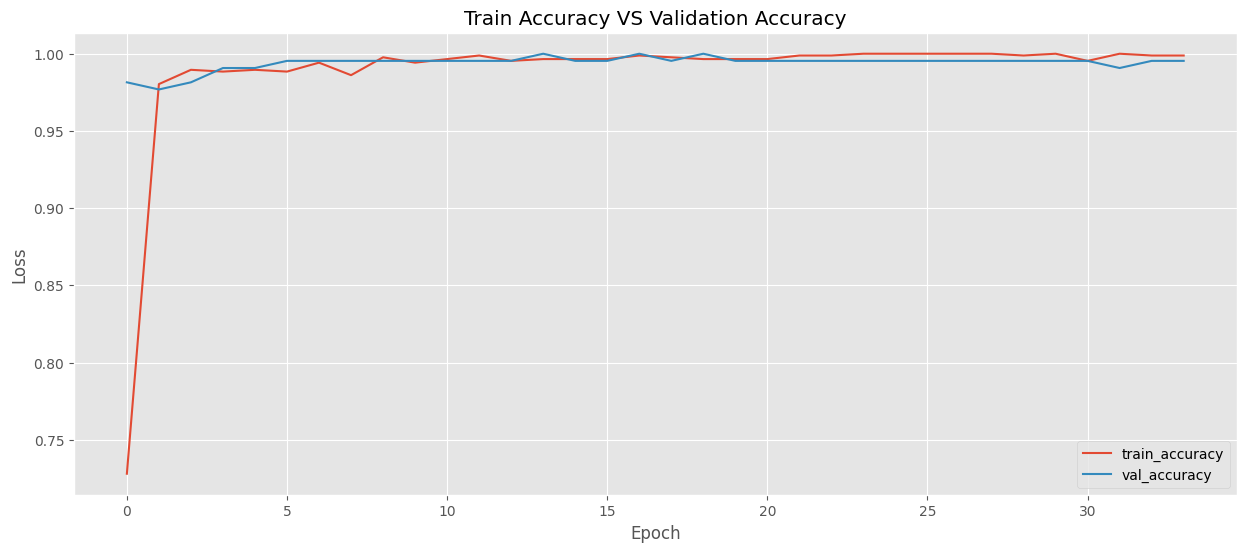

In [28]:
model_result["history"][["train_accuracy", "val_accuracy"]].plot(figsize=(15, 6),
                                                                 title="Train Accuracy VS Validation Accuracy",
                                                                 xlabel="Epoch",
                                                                 ylabel="Loss")
plt.show()